# BESS-JPL Accuracy Analysis with ECOv002 Cal-Val

This notebook performs accuracy analysis of the BESS-JPL model using ECOSTRESS Collection 2 Cal-Val data.

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the BESS-JPL model, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from BESS_JPL import process_BESS_table
from BESS_JPL import process_BESS_table, load_ECOv002_calval_BESS_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed, sensitivity_magnitude_barchart
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
save_plots = False  # toggle to save plot image files

## Define Processing Function for Model Table

This cell defines the forward process for analysis as the BESS-JPL model.

In [3]:
forward_process = process_BESS_table
model_name = "BESS-JPL"

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [4]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out surface temperatures greater than 50 Celsius and NDVI values less than 0.05. The resulting DataFrame is displayed for inspection.

In [15]:
# from ECOv003_L3T_L4T_JET import load_ECOv002_calval_JET_inputs
# input_df = load_ECOv002_calval_JET_inputs()
input_df = load_ECOv002_calval_BESS_inputs()
input_df = input_df[input_df.ST_C <= 50]
input_df = input_df[input_df.NDVI.apply(lambda NDVI: NDVI > 0.05)]

# Convert time_UTC to ISO8601 format for BESS_JPL compatibility
# input_df['time_UTC'] = pd.to_datetime(input_df['time_UTC'], format='%m/%d/%y %H:%M').dt.strftime('%Y-%m-%dT%H:%M:%S')

input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,ball_berry_intercept_C3,CI,canopy_height_meters,day_of_year,hour_of_day,lat,lon,wind_speed_mps,PAR_albedo,NIR_albedo
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,0.005267,0.282353,20.642902,275,14.039600,35.7990,-76.6560,2.186025,0.093910,0.355875
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,0.009882,0.286275,0.000000,174,12.907533,41.8222,-80.6370,0.407237,0.025246,0.203385
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,0.009882,0.286275,0.000000,178,11.207533,41.8222,-80.6370,0.670782,0.025532,0.203525
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,0.009882,0.286275,0.000000,181,10.357533,41.8222,-80.6370,1.621847,0.018327,0.145013
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,0.009882,0.286275,0.000000,182,9.507533,41.8222,-80.6370,0.588098,0.026074,0.205243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,0.015000,0.301961,0.000000,345,9.412747,35.4106,-99.0588,2.986896,0.039903,0.133085
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,0.015000,0.301961,0.000000,84,16.146080,35.4106,-99.0588,3.797659,0.046732,0.195446
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,0.015000,0.301961,0.000000,102,16.279413,35.4106,-99.0588,5.729455,0.043653,0.185123
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,0.015000,0.301961,0.000000,104,8.146080,35.4106,-99.0588,3.790757,0.039729,0.154615


## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the model, and displays the resulting DataFrame.

In [16]:
processed = forward_process(input_df)
processed

[2026-01-29 15:39:36 INFO] started extracting geometry from BESS input table
[2026-01-29 15:39:36 INFO] completed extracting geometry from BESS input table (0.02 seconds)
[2026-01-29 15:39:36 INFO] started extracting time from BESS input table
[2026-01-29 15:39:36 INFO] completed extracting time from BESS input table (0.00 seconds)
[2026-01-29 15:39:36 INFO] started calculating day of year and hour of day
[2026-01-29 15:39:36 INFO] completed calculating day of year and hour of day (0.02 seconds)
[2026-01-29 15:39:36 INFO] started extracting geometry
[2026-01-29 15:39:36 INFO] completed extracting geometry (0.01 seconds)
[2026-01-29 15:39:36 INFO] started retrieving BESS inputs
[2026-01-29 15:39:36 INFO] All GEOS-5 FP inputs provided, no retrieval needed.
[2026-01-29 15:39:36 INFO] finished retrieving BESS inputs (0.00 seconds)
<class 'numpy.ndarray'>
float32
[2026-01-29 15:39:36 INFO] variable SZA_deg min: 9.294 mean: 45.845 max: 72.168 nan: 0.00% (nan)
[2026-01-29 15:39:36 INFO] varia

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,GPP_daily,Rn_Wm2,Rn_soil_Wm2,Rn_canopy_Wm2,LE_Wm2,LE_soil_Wm2,LE_canopy_Wm2,Rn_daylight_Wm2,LE_daylight_Wm2,ET_daylight_kg
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,5.700748,467.921340,299.737212,168.184128,223.341548,59.766873,163.574674,279.241293,144.378084,2.479295
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,8.643958,707.294987,541.322904,165.972083,227.447710,95.422502,132.025207,366.788297,131.667745,2.910873
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,8.057099,677.491732,512.168485,165.323247,310.612154,180.112304,130.499850,349.830162,178.920122,3.952179
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,10.348253,691.635872,510.437322,181.198551,327.123457,195.135141,131.988315,374.130536,196.177294,4.327450
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,10.170976,550.709088,410.178694,140.530394,238.687570,129.094104,109.593466,323.547150,156.117333,3.441726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,0.193353,230.689725,162.751447,67.938278,47.118606,40.679538,6.439069,176.197960,41.157166,0.584566
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,0.878352,248.727296,179.192392,69.534903,42.248825,29.170917,13.077908,265.116535,51.665881,0.921884
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,2.398911,387.288199,254.536304,132.751895,48.185939,5.935990,42.249950,396.482760,54.209416,1.019800
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,1.200992,293.725937,233.354399,60.371538,56.800909,45.770630,11.030279,253.802358,57.636411,1.090288


## Accuracy Comparison of In-Situ Observations to Model Estimates

Examining the accuracy of model estimates compared to ground data.

analyzing BESS-JPL accuracy for ET_daylight_kg compared to insitu_ET_daylight_kg


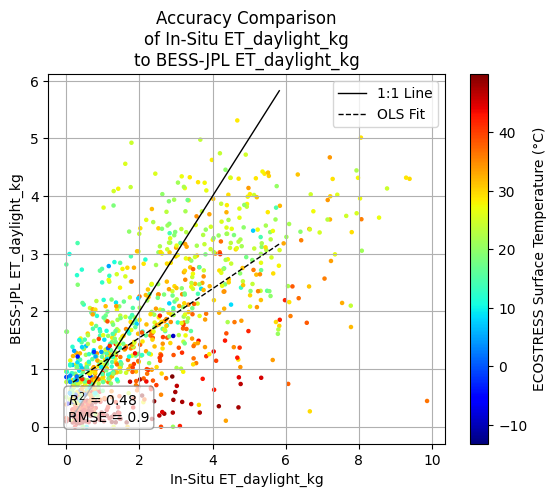

analyzing BESS-JPL accuracy for G_Wm2 compared to insitu_G_Wm2


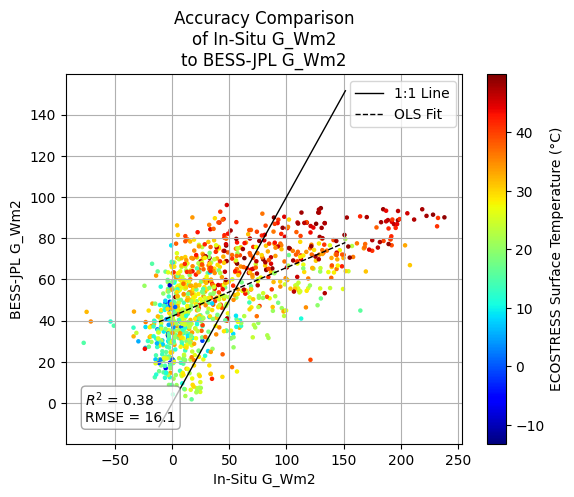

analyzing BESS-JPL accuracy for LE_Wm2 compared to insitu_LE_Wm2


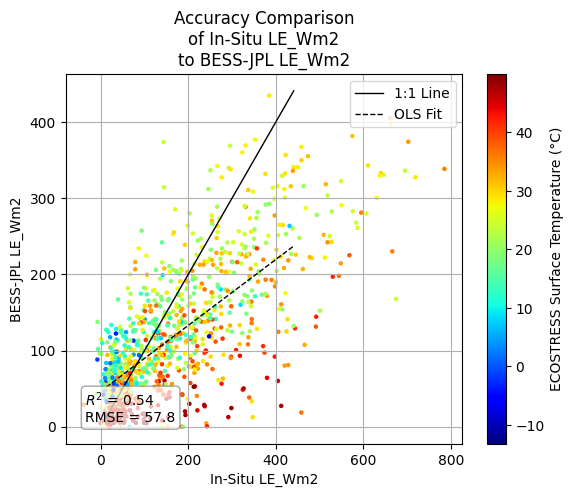

analyzing BESS-JPL accuracy for LE_daylight_Wm2 compared to insitu_LE_daylight_Wm2


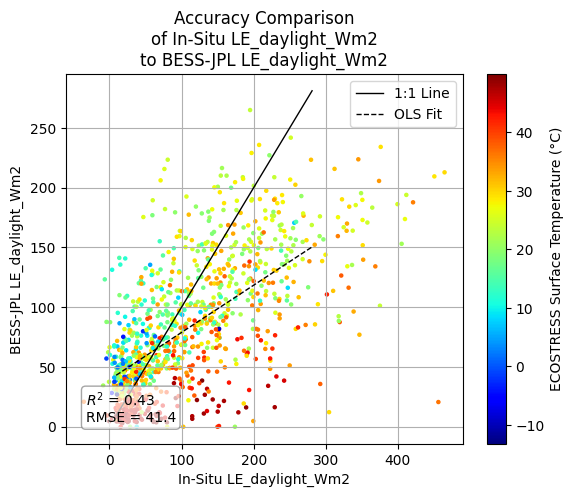

analyzing BESS-JPL accuracy for Rn_Wm2 compared to insitu_Rn_Wm2


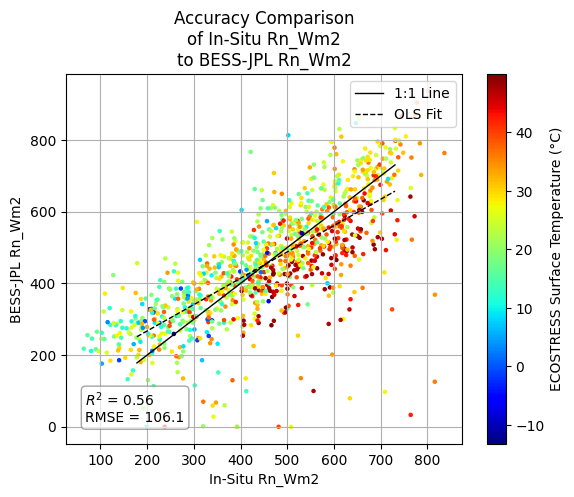

analyzing BESS-JPL accuracy for Rn_daylight_Wm2 compared to insitu_Rn_daylight_Wm2


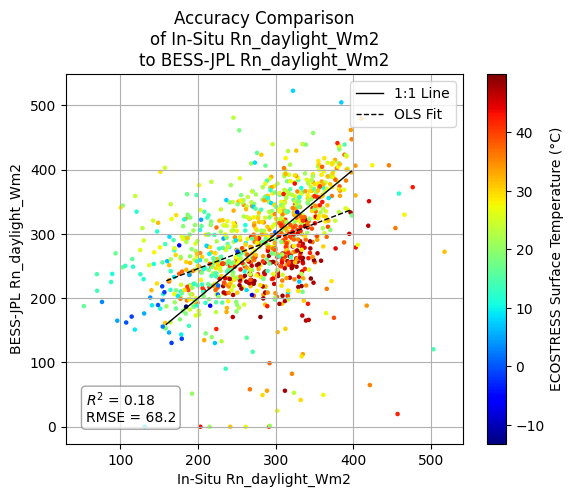

analyzing BESS-JPL accuracy for SWin_Wm2 compared to insitu_SWin_Wm2


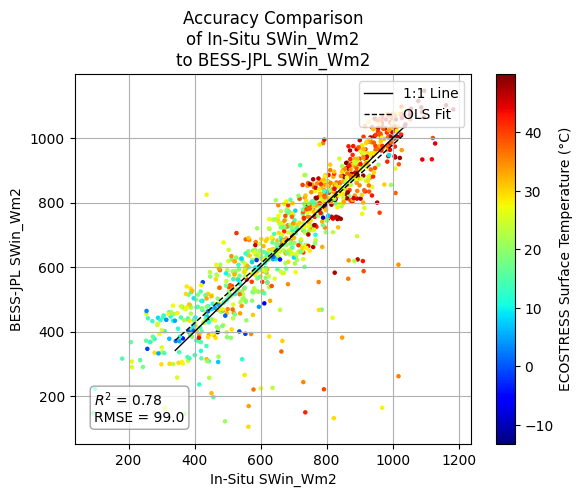

In [17]:
insitu_columns = sorted([column for column in processed.columns if "insitu" in column])
insitu_columns.remove("insitu_H_Wm2")

for insitu_variable in insitu_columns:
    variable = insitu_variable.replace("insitu_", "")
    print(f"analyzing {model_name} accuracy for {variable} compared to {insitu_variable}")
    
    x_variable = insitu_variable
    y_variable = variable

    # Filter out rows with NaN values in either variable
    valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
    
    sc = plt.scatter(
        x=valid_data[x_variable],
        y=valid_data[y_variable],
        c=valid_data.ST_C,
        cmap="jet",
        color=None,
        s=5
    )

    # Calculate 5% and 95% tails for x and y variables
    x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
    y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

    min_val = min(x_5th, y_5th)
    max_val = max(x_95th, y_95th)

    # Add 1-to-1 line
    # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
    # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

    # Add OLS regression line
    coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
    ols_x = np.array([min_val, max_val])
    ols_y = coefs[0] * ols_x + coefs[1]
    plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

    # Calculate R-squared and RMSE
    from sklearn.metrics import r2_score, mean_squared_error
    y_true = valid_data[y_variable]
    y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Annotate R-squared and RMSE on plot in lower left corner
    plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                xy=(0.05, 0.05), xycoords='axes fraction',
                ha='left', va='bottom',
                fontsize=10,
                bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

    # Set ticks every 100 for both axes
    # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
    # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
    # plt.xticks(xticks)
    # plt.yticks(yticks)

    plt.grid(True, zorder=0) 
    plt.xlabel(f"In-Situ {variable}")
    plt.ylabel(f"{model_name} {variable}")
    plt.title(f"Accuracy Comparison\nof In-Situ {variable}\nto {model_name} {variable}")
    plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
    plt.legend(loc='upper right')
    if save_plots:
        plt.savefig(f"Accuracy Comparison of In-Situ {variable} to {model_name} {variable}.jpeg", format='jpeg', bbox_inches='tight')
        plt.savefig(f"Accuracy Comparison of In-Situ {variable} to {model_name} {variable}.svg", format='svg', bbox_inches='tight')
    plt.show()
        
    


## Plot Unperturbed Comparison of Surface Temperature to Net Radiation

This cell creates a scatter plot comparing ECOSTRESS surface temperature to net radiation for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

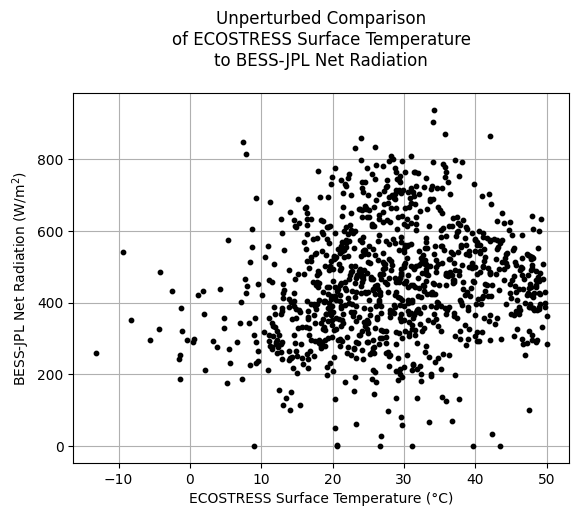

In [8]:
plt.scatter(x=processed.ST_C, y=processed.Rn_Wm2, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Net Radiation (W/m$^2$)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Net Radiation", pad=20)

if save_plots:
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.svg", format='svg', bbox_inches='tight')
plt.show()


## Plot Unperturbed Comparison of Surface Temperature to Evapotranspiration

This cell creates a scatter plot comparing ECOSTRESS surface temperature to BESS-JPL evapotranspiration for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

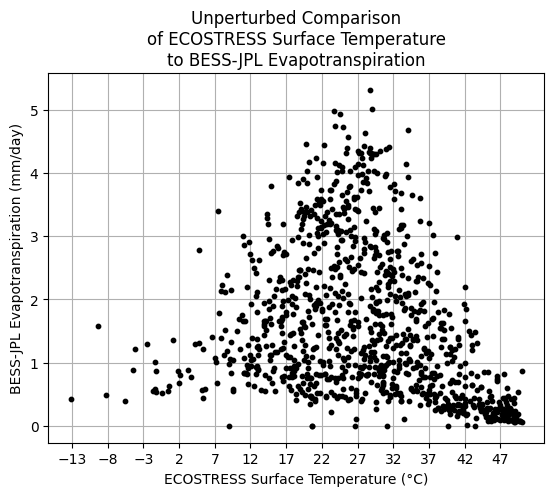

In [9]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.ET_daylight_kg, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Evapotranspiration (mm/day)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Evapotranspiration")
if save_plots:
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.svg", format='svg', bbox_inches='tight')

plt.show()
